**"We certify that the code and data in this assignment were generated independently, using
only the tools and resources defined in the course and that I/we did not receive any external
help, coaching or contributions during the production of this work."**

In [5]:
!pip install gym
!pip install pygame

In [1]:
import gym, os
from itertools import count
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import math

In [2]:
torch.manual_seed(1404752779687100)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
env = gym.make('CartPole-v1')
print(env.observation_space)
print(env.action_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


In [5]:
env.observation_space.shape[0]

4

In [6]:
class Actor(nn.Module):

    def __init__(self):
        super(Actor, self).__init__()
        # input - 2
        # output - 3 (action probabilities)
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16,16)
        #self.fc3 = nn.Linear(512, 128)
        #self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(16,2)
       

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x),dim=0)
        
        return x

In [7]:
class Critic(nn.Module):

    def __init__(self):
        super(Critic, self).__init__()
        # input - 2
        # output - 3 (action probabilities)
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64,32)
        #self.fc3 = nn.Linear(256, 128)
        #self.fc4 = nn.Linear(128, 128)
        self.fc5 = nn.Linear(32,1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        return x

In [8]:
actor = Actor().to(device)
critic = Critic().to(device)
#target_critic = Critic().to(device)
env = gym.make("CartPole-v1")
max_episodes= 4600+1
env.reset()
list_r=[]

log_probs = []
values = []
rewards = []
masks = []

update = 20
gamma = 0.99

lr_a = 0.001
lr_c = 0.001

optimizer_a = torch.optim.Adam(actor.parameters(), lr= lr_a)
optimizer_c = torch.optim.Adam(critic.parameters(), lr= lr_c)

#critic_loss = torch.nn.MSELoss()
#actor_loss = torch.nn.CrossEntropyLoss()


for i in range(max_episodes):
    done=False
    state= env.reset()
    r=0
    u = 0 
    d = 1 
    log_probs = []
    values = []
    rewards = []
    masks = []
    episode_entropy = 0
   
    loss_a_list = []
    actor_losses= 0
    q_val = 0
    while not done:
        value = critic(torch.Tensor(state))
        act_prob = actor(torch.Tensor(state))

        #detaching to numbers for calculation
        value = value.detach().numpy()[0]
        prob = act_prob.detach().numpy() 
        #sample an action
        action = torch.multinomial(act_prob,1 ).detach().numpy()[0]

        log_prob = torch.log(act_prob.squeeze(0)[action])

        entropy = -np.sum(np.mean(prob) * np.log(prob))

        #pass action in env
        next_state,reward,done, info = env.step(action)
        r+=reward


        rewards.append(reward)
        values.append(value)
        log_probs.append(log_prob)
        episode_entropy += entropy
        state = next_state

        qval = critic(torch.Tensor(next_state))
        qval = qval.detach().numpy()[0]

    qvals = np.zeros_like(values)
    for t in reversed(range(len(rewards))):
        qval = rewards[t] + gamma * qval
        qvals[t] = qval

    values = torch.FloatTensor(values)
    qvals = torch.FloatTensor(qvals)
    log_probs = torch.stack(log_probs)

    advantage = qvals - values

    actor_loss = (-log_probs * advantage).mean() + 0.001 * episode_entropy
    critic_loss = 0.5 * advantage.pow(2).mean()  + 0.001 * episode_entropy
    critic_loss.requires_grad =True

    optimizer_a.zero_grad()
    optimizer_c.zero_grad()

    actor_loss.backward()
    critic_loss.backward()

    optimizer_a.step()
    optimizer_c.step()   
    

    list_r.append(r)
    if i%10 == 0:
        print("Episode: ",i," Last avg reward: ",sum(list_r[-10:])/10)
    if sum(list_r[-7:])/7 >= 450:
        print(f"Enough Training!!")
        break


Episode:  0  Last avg reward:  1.8
Episode:  10  Last avg reward:  18.6
Episode:  20  Last avg reward:  25.1
Episode:  30  Last avg reward:  28.1
Episode:  40  Last avg reward:  25.1
Episode:  50  Last avg reward:  20.0
Episode:  60  Last avg reward:  26.8
Episode:  70  Last avg reward:  19.5
Episode:  80  Last avg reward:  15.5
Episode:  90  Last avg reward:  18.7
Episode:  100  Last avg reward:  21.3
Episode:  110  Last avg reward:  20.6
Episode:  120  Last avg reward:  20.9
Episode:  130  Last avg reward:  26.2
Episode:  140  Last avg reward:  22.2
Episode:  150  Last avg reward:  19.8
Episode:  160  Last avg reward:  17.8
Episode:  170  Last avg reward:  22.0
Episode:  180  Last avg reward:  19.3
Episode:  190  Last avg reward:  25.2
Episode:  200  Last avg reward:  20.0
Episode:  210  Last avg reward:  20.4
Episode:  220  Last avg reward:  25.7
Episode:  230  Last avg reward:  29.2
Episode:  240  Last avg reward:  26.2
Episode:  250  Last avg reward:  22.6
Episode:  260  Last avg 

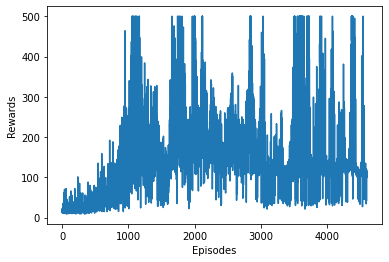

In [9]:
plt.plot(list_r)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

In [58]:
 torch.seed() #1404752779687100

1404752779687100

In [67]:
# torch.save(actor.state_dict(), 'actor_cartpole.pt')

In [12]:
actor = Actor().to(device)
actor.load_state_dict(torch.load('actor_cartpole.pt'))

<All keys matched successfully>

In [17]:
actor.eval()
list_re = []
for i in range(10):
    done=False
    state= env.reset()
    r=0
    env.render()
    while not done:
        
        act_prob = actor(torch.Tensor(state))
        action = torch.multinomial(act_prob,1 ).detach().numpy()[0]
        next_state,reward,done, info = env.step(action)
        r+= reward
        state = next_state
        
    list_re.append(r)   
    print("Episode: ",i," Last avg reward: ",list_re[-1])

Episode:  0  Last avg reward:  384.0
Episode:  1  Last avg reward:  500.0
Episode:  2  Last avg reward:  179.0
Episode:  3  Last avg reward:  500.0
Episode:  4  Last avg reward:  227.0
Episode:  5  Last avg reward:  310.0
Episode:  6  Last avg reward:  500.0
Episode:  7  Last avg reward:  66.0
Episode:  8  Last avg reward:  500.0
Episode:  9  Last avg reward:  371.0


[384.0, 500.0, 179.0, 500.0, 227.0, 310.0, 500.0, 66.0, 500.0, 371.0]


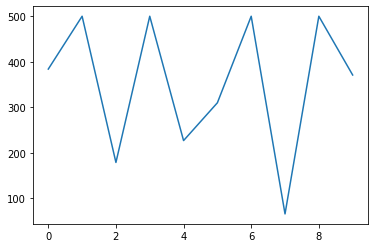

In [18]:
print(list_re)
plt.plot(list_re)

In [1]:
print(list_re)
plt.plot(list_re)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Rewards")

NameError: name 'list_re' is not defined

**Reference:**

- https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f